# Bgee

Extracting data from [Bgee](http://bgee.org/). See [this Thinklab discussion](http://thinklab.com/discussion/tissue-specific-gene-expression-resources/81#278) for more information.

In [1]:
import collections
import gzip

import pandas
import seaborn
import numpy
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [2]:
def get_groupby_counts(df, columns):
    """Group datagrame by columns and return the number of rows for each grouping."""
    grouped = df.groupby(columns)
    get_len = lambda df: pandas.Series({'count': len(df)})
    df = grouped.apply(get_len)
    df = df.sort_values('count', ascending=False)
    df = df.reset_index()
    return df

## Load entrez gene for ensembl conversion

In [3]:
# Read Entrez Genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/5352b31e04ec136e99d25a0ba63e8867aa71b69f/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)    
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']

ensembl_to_entrez = dict(zip(entrez_map_df.identifier, entrez_map_df.GeneID))

## Load adult developmental stages

In [4]:
stage_df = pandas.read_table('data/stages.tsv')
stage_df = stage_df.query("is_adult == 1")
adult_stages = set(stage_df.stage_id)
len(adult_stages)

70

## Read and process presence of expression data

In [5]:
# Read expression
presence_df = pandas.read_table('download/Homo_sapiens_expr-simple.tsv.gz')
presence_df.head(2)

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,HsapDv:0000092,human middle aged stage (human),present,poor quality
1,ENSG00000000003,TSPAN6,CL:0000019,sperm,HsapDv:0000088,human early adulthood stage (human),present,poor quality


### Contingency table (as percents) of `Expression` versus `Call quality`

In [6]:
pandas.crosstab(presence_df['Expression'].fillna('NA'), presence_df['Call quality']) / len(presence_df)

Call quality,high quality,poor quality
Expression,,
absent,0.416251,0.000000
present,0.409678,0.161998


In [7]:
# Apply filters for gene presence
present_df = presence_df[presence_df['Developmental stage ID'].isin(adult_stages)]
present_df = present_df[
    present_df['Expression'].isin({'present'}) &
    present_df['Call quality'].isin({'high quality'})
]
present_df = present_df[['Gene ID', 'Anatomical entity ID', 'Expression']].drop_duplicates()
present_df.head(2)

,Gene ID,Anatomical entity ID,Expression
11,ENSG00000000003,CL:0002328,present
15,ENSG00000000003,CL:0002336,present


In [8]:
# filter to human adult stage (human)
pivoted_df = present_df.pivot('Gene ID', 'Anatomical entity ID', 'Expression')
pivoted_df = (pivoted_df == 'present').astype(int)

# convert to entrez GeneIDs
pivoted_df = pivoted_df.groupby(ensembl_to_entrez).max()
pivoted_df.index.name = 'entrez_gene_id'
pivoted_df = pivoted_df.reset_index()
pivoted_df.entrez_gene_id = pivoted_df.entrez_gene_id.astype(int)

# save dataframe
with gzip.open('data/present-in-adult.tsv.gz', 'wt') as write_file:
    pivoted_df.to_csv(write_file, sep='\t', index=False)

# see tail
pivoted_df.tail(2)

Anatomical entity ID,entrez_gene_id,CL:0000015,CL:0000019,CL:0000023,CL:0000115,CL:0000169,CL:0000738,CL:0000842,CL:0002092,CL:0002328,...,UBERON:0008188,UBERON:0009834,UBERON:0009835,UBERON:0010414,UBERON:0011876,UBERON:0013540,UBERON:0013541,UBERON:0013554,UBERON:0014892,UBERON:0016525
18960,105379030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18961,105379175,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Coding genes in entrez dataset
len(set(pivoted_df.entrez_gene_id) & coding_genes)

16257

In [10]:
# Frequency of gene presence 
pivoted_df.drop('entrez_gene_id', 1).as_matrix().mean()

0.32278667076594397

In [11]:
# Total number of anatomy-gene presence edges
pivoted_df.drop('entrez_gene_id', 1).as_matrix().sum()

1150688

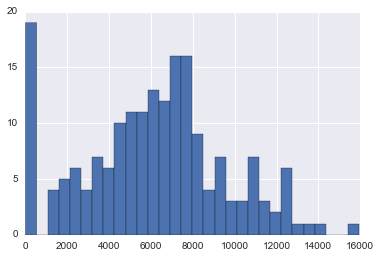

In [12]:
# Number of genes present per tissue
ax = pivoted_df.drop('entrez_gene_id', 1).sum().hist(bins=30)

## Read and process differential expression data

In [13]:
# Read simple differential expression by anatomy
diffex_df = pandas.read_table('download/Homo_sapiens_diffexpr-anatomy-simple.tsv.gz', compression='gzip')
diffex_df.head(2)

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Differential expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,UBERON:0000113,post-juvenile adult stage,over-expression,low quality
1,ENSG00000000003,TSPAN6,CL:0000738,leukocyte,UBERON:0000113,post-juvenile adult stage,under-expression,high quality


### Contingency table (as percents) of `Differential expression` versus `Call quality`

Documentation of `Differential expression` and `Call quality` is [below](http://bgee.org/?page=doc&action=call_files#single_diff_simple_col7):

> #### Differential expression (column 7)
Call generated from all data types for Gene ID (column 1), in Anatomical entity ID (column 3), at Developmental stage ID (column 5). One of:
+ **over-expression**: the gene was shown in one or more analyses to have a significant over-expression in this condition, as compared to the expression levels in other conditions of the analyses.
+ **under-expression**: the gene was shown in one or more analyses to have a significant under-expression in this condition, as compared to the expression levels in other conditions of the analyses.
+ **weak ambiguity**: there exists a call of over-expression or under-expression generated from a data type, but another data type showed no significant variation of the level of expression of this gene in the same condition; or, a gene was shown to be never expressed in a condition by some analyses of a given data type, but other analyses of different data types produced a call of over-expression or of absence of differential expression for the same gene, in the same condition (note that conflicts where a data type produced an under-expression call in a condition, while another data type showed the same gene to be never expressed in that condition, do not produce a weak ambiguity call, but a call of under-expression low quality).
+ **strong ambiguity**: there exists a call of over-expression or under-expression generated from a data type, but there exists a call in the opposite direction generated from another data type for the same gene, anatomical entity and developmental stage. For instance, gene A is reported to be over-expressed in the midbrain at young adult stage from Affymetrix data, but is reported to be under-expressed in the midbrain at young adult stage from RNA-Seq data.

> #### Call quality (column 8)
Confidence in the differential expression call provided in Differential expression (column 7). One of:
+ **high quality**: differential expression reported as high quality, with no contradicting call from same type of analysis (across anatomy/across life stages), for same gene, in same anatomical entity and developmental stage, (call generated either from multiple congruent analyses, or from a single analysis).
+ **poor quality**: differential expression reported as low quality, or there exists a conflict for the same gene, anatomical entity and developmental stage, from different analyses of a same data type (conflicts between different data types are treated differently). For instance, an analysis showed a gene to be over-expressed in a condition, while another analysis showed the same gene to be under-expressed or not differentially expressed in the same condition. Such conflicts are resolved by a voting system based on the number of conditions compared, weighted by p-value. Note that in one case, this quality level is used to reconcile conflicting calls from different data types: when a data type produced an under-expression call, while a different data type has shown that the same gene was never seen as expressed in the same condition. In that case, the overall summary is under-expression low quality.
+ **NA**: no quality applicable when ambiguity state in Differential expression (column 7).

In [14]:
pandas.crosstab(diffex_df['Call quality'].fillna('NA'), diffex_df['Differential expression']) / len(diffex_df)

Differential expression,high ambiguity,low ambiguity,over-expression,under-expression
Call quality,,,,
NA,0.024854,0.155769,0.000000,0.000000
high quality,0.000000,0.000000,0.211081,0.196327
low quality,0.000000,0.000000,0.176314,0.235655


In [15]:
# filter differential expression
diffex_df = diffex_df[
    diffex_df['Differential expression'].isin({'over-expression', 'under-expression'}) &
    diffex_df['Call quality'].isin({'low quality', 'high quality'})
]

In [25]:
# Calculate counts per anatomy--DE pair
de_anatomy_df = get_groupby_counts(diffex_df, ['Anatomical entity ID', 'Anatomical entity name', 'Differential expression'])
de_anatomy_df.head()

,Anatomical entity ID,Anatomical entity name,Differential expression,count
0,CL:0000738,leukocyte,under-expression,12406
1,UBERON:0000473,testis,over-expression,10267
2,UBERON:0002369,adrenal gland,over-expression,9079
3,UBERON:0000955,brain,over-expression,8485
4,UBERON:0002369,adrenal gland,under-expression,7989


### Figure 2: Number of differntially expressed genes present by anatomical entity

/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/dhimmels/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self.set_edgecolor(c)


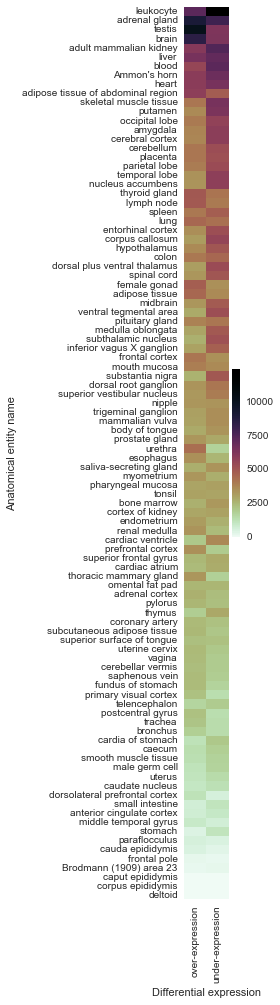

In [17]:
# Plot DE counts
rect_df = de_anatomy_df.pivot('Anatomical entity name', 'Differential expression', 'count').fillna(0)
rect_df['differential expression'] = rect_df['under-expression'] + rect_df['over-expression']
rect_df = rect_df.sort('differential expression', ascending=False)
IPython.core.pylabtools.figsize(1, 16)
cmap = seaborn.cubehelix_palette(15, start=2.2, rot=1, gamma=1.6, hue=1, light=0.98, dark=0, as_cmap=True)
seaborn.heatmap(rect_df.drop('differential expression', axis=1), cmap=cmap);

In [18]:
diffex_pivot_df = diffex_df.pivot('Gene ID', 'Anatomical entity ID', 'Differential expression')
diffex_pivot_df = diffex_pivot_df.replace({'under-expression': -1, 'over-expression': 1, numpy.NaN: 0})

In [19]:
def round_diffex(value):
    if value <= -0.5:
        return -1
    if value >= 0.5:
        return 1
    return 0

diffex_pivot_df = diffex_pivot_df.groupby(ensembl_to_entrez).mean().applymap(round_diffex)

In [20]:
diffex_pivot_df = diffex_pivot_df.reset_index()
diffex_pivot_df = diffex_pivot_df.rename(columns=({'index': 'GeneID'}))
diffex_pivot_df.GeneID = diffex_pivot_df.GeneID.astype(int)

# save dataframe
with gzip.open('data/diffex.tsv.gz', 'wt') as write_file:
    diffex_pivot_df.to_csv(write_file, sep='\t', index=False)

# see tail
diffex_pivot_df.tail()

Anatomical entity ID,GeneID,CL:0000015,CL:0000738,UBERON:0000002,UBERON:0000007,UBERON:0000029,UBERON:0000044,UBERON:0000057,UBERON:0000082,UBERON:0000178,...,UBERON:0005363,UBERON:0007227,UBERON:0007318,UBERON:0007371,UBERON:0007808,UBERON:0009834,UBERON:0009835,UBERON:0010414,UBERON:0011876,UBERON:0013554
18615,105378753,0,0,0,0,-1,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18616,105378933,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18617,105378966,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
18618,105379030,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
18619,105379175,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Coding genes in entrez dataset
len(set(diffex_pivot_df.GeneID) & coding_genes)

16184